# Polarization of Presidential Candidates

#### Setup
Import csvs, combine, and also split by party

In [2]:
def read_in_tloc_line(line, is_senate): 
    if is_senate: 
        chamber = "senate"
    else: 
        chamber = "house"
    split_line = line.split(",")
    if len(split_line)!=7: 
        return {"date":"", "title":"", "speaker":"", "text":"", "party":"", "dwnom1":"", "dwnom2":""}
    else: 
        party = split_line[4]
        if party == u'200':
            party = 1 # Republicans 
        else: 
            #party = -1
            party = 0

        return {"date":split_line[0], "title":split_line[1], "speaker":split_line[2], "text":split_line[3], "party":party, "chamber":chamber, "dwnom1":split_line[5], "dwnom2":split_line[6]}

def read_in_candidate_line(line): 
    split_line = line.split(",")

    return {"speaker":split_line[0], "type":split_line[1], "text":split_line[2], "title":split_line[3], "date":split_line[4]}

house_raw = sc.textFile('econ407/house_speakers_dict.csv', minPartitions=20).map(lambda x: read_in_tloc_line(x, False))
senate_raw = sc.textFile('econ407/senate_speakers_dict.csv', minPartitions=20).map(lambda x: read_in_tloc_line(x, True))
all_cong = house_raw.union(senate_raw)

all_republicans = all_cong.filter(lambda x: x['party']==1)
all_democrats = all_cong.filter(lambda x: x['party']==0) ## CHANGE THIS IF USING -1 FOR DEM 
all_cong = all_republicans.union(all_democrats)
all_other_party = all_cong.filter(lambda x: x['party'] not in [0, 1])

candidates_raw = sc.textFile('econ407/final_candidate_data.csv', minPartitions=20).map(read_in_candidate_line)

### Creating bigram representation: 

##### Parse into lists of words

In [3]:
import re
from stemming.porter2 import stem # Note: you need to install 'stemming' on each slave + master via ssh 

def parse_text(x): 
    ''' 
    Parses full text and returns words. Removes punctuation, numbers, and stop words. Stop word list is from http://xpo6.com/list-of-english-stop-words/
    Also uses a porter stemmer to stem each word. So "pour" "poured" "pouring" would all become "pour" 
    '''
    stopwords = open('econ407/stop_words.txt', 'r').read().split()
    #stopwords = ["i", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]
    words = x['text'].lower()
    words = re.sub('[^A-Za-z]+', ' ', words)
    x['words'] = [w for w in words.split() if w not in stopwords]
    x['words'] = [stem(w) for w in x['words']]
    x['words'] = [w for w in x['words'] if len(w)>1]
    x.pop("text")
    return x

parsed_republicans = all_republicans.map(parse_text)
parsed_democrats = all_democrats.map(parse_text)
parsed_all_cong = all_cong.map(parse_text)
parsed_candidates = candidates_raw.map(parse_text)

##### Create bigrams from list of processed words 

In [4]:
def create_bigrams(x): 
    text = " ".join(x['words'])
    if len(text)<10: 
        x['bigrams'] = []
        return x
    bigrams = [b for b in zip(text.split(" ")[:-1], text.split(" ")[1:])]
    x['bigrams'] = bigrams
    x['num_bigrams'] = len(bigrams)
    return x

republican_bigrams = parsed_republicans.map(create_bigrams)
democrat_bigrams = parsed_democrats.map(create_bigrams)
candidates_bigrams = parsed_candidates.map(create_bigrams)
all_cong_bigrams = parsed_all_cong.map(create_bigrams)

In [5]:
republican_bigrams_counts = republican_bigrams.flatMap(lambda x: x['bigrams']).countByValue().items()
republican_bigrams_counts.sort(key = lambda x: x[1], reverse=True)

In [6]:
democrat_bigrams_counts = democrat_bigrams.flatMap(lambda x: x['bigrams']).countByValue().items()
democrat_bigrams_counts.sort(key = lambda x: x[1], reverse=True)

In [7]:
all_cong_bigrams_counts = all_cong_bigrams.flatMap(lambda x: x['bigrams']).countByValue().items()
all_cong_bigrams_counts.sort(key = lambda x: x[1], reverse=True)

In [8]:
candidates_bigrams_counts = candidates_bigrams.flatMap(lambda x: x['bigrams']).countByValue().items()
candidates_bigrams_counts.sort(key = lambda x: x[1], reverse=True)

#### Create list of bigrams to use as represenation
There are 796,319 unique bigrams. A lot of them are junk. We'll keep them based on the following criteria:

    1) not in the top 50 for both reps and dems
    2) appears in at least 15 different speeches
    3) appears X times? 
    

In [9]:
len(all_cong_bigrams_counts)

796319

In [10]:
# list of num of documents each bigram appears in 
def drop_duplicates(x): 
    temp = x['bigrams']
    x['bigrams'] = list(temp)
    return x

bigrams_nodups = all_cong_bigrams.map(drop_duplicates)
bigrams_doc_count = bigrams_nodups.flatMap(lambda x: x['bigrams']).countByValue().items()

In [11]:
import numpy as np
sorted_bigrams_doc_count = sorted(bigrams_doc_count, key=lambda x: x[1], reverse=True)
doc_count = np.array([x[1] for x in sorted_bigrams_doc_count])
print "The 99th ptile is %d documents" % np.percentile(doc_count, 99)
print "The 90th ptile is %d documents" % np.percentile(doc_count, 90)
print "The 80th ptile is %d documents" % np.percentile(doc_count, 80)
print "The 75th ptile is %d documents" % np.percentile(doc_count, 75)
print "The 60th ptile is %d documents" % np.percentile(doc_count, 60)
print "The 50th ptile is %d documents" % np.percentile(doc_count, 50)
print "The 40th ptile is %d documents" % np.percentile(doc_count, 40)
print "The 25th ptile is %d documents" % np.percentile(doc_count, 25)
print "The 15th ptile is %d documents" % np.percentile(doc_count, 15)
print "The 5th ptile is %d documents" % np.percentile(doc_count, 5)

The 99th ptile is 20 documents
The 90th ptile is 4 documents
The 80th ptile is 2 documents
The 75th ptile is 2 documents
The 60th ptile is 1 documents
The 50th ptile is 1 documents
The 40th ptile is 1 documents
The 25th ptile is 1 documents
The 15th ptile is 1 documents
The 5th ptile is 1 documents


In [12]:
len([l for l in sorted_bigrams_doc_count if l[1]>15])

11537

In [13]:
from random import shuffle
def create_bigrams_rep_and_map(all_bigrams, dem_bigrams, rep_bigrams, doc_counts):
    shuffle(all_bigrams)
    
    doc_cutoff = 15
    top_both_cutoff = 50
    total_mention_cutoff = 15
    
    # keep only with over cutoff mentions
    rv = [l[0] for l in all_bigrams if l[1]>total_mention_cutoff]
    
    # not in top total_mention_cutoff of both rep and dem bigrams
    top_rep = [l[0] for l in rep_bigrams[:top_both_cutoff]]
    top_dem = [l[0] for l in dem_bigrams[:top_both_cutoff]]
    top_both = [l for l in top_rep if l in top_dem]
    rv = [l for l in rv if l not in top_both]
    
    # in more than doc_cutoff documents 
    bigrams_over_doc_cutoff = [l[0] for l in doc_counts if l[1]>doc_cutoff]
    rv = [l for l in rv if l in bigrams_over_doc_cutoff]
    
    # Some extra crap
    procedural_bigrams = [(u'remind', u'speaker'), (u'rollcal', u'motion'), (u'hous', u'major'),(u'file', u'amend'),\
                      (u'rollcal', u'motion'), (u'introduc', u'resolut'), (u'book', u'call'), (u'lehtinen', u'speaker'),
                     (u'amend', u'minut'), (u'presid', u'speaker'), (u'oppos', u'bill'), (u'speaker', u'democrat'), (u'hous', u'chamber'), 
                    (u'congression', u'poverti'), (u'seventh', u'congression'), (u'amend', u'minut'), (u'opposit', u'call'), 
                     (u'inquir', u'schedul'),  (u'schedul', u'week'),  (u'bill', u'text'),  (u'move', u'suspend'),  (u'purpos', u'clerk'), 
                          (u'mile', u'colorado'),  (u'address', u'floor'),  (u'page', u'regul'),  (u'hollen', u'chairman'),  (u'read', u'title'), 
                          (u'text', u'bill'),  (u'barbara', u'lee'), (u'time', u'ms'), (u'build', u'clerk'), (u'house', u'meet'),(u'meet', u'noon'),
                          (u'congresswoman', u'christensen'), (u'recomit', u'desk'), (u'capitol', u'due'), (u'read', u'titl'),(u'purpos', u'inquir'),
                          (u'progress', u'messag'), (u'leader', u'harri'),(u'reed', u'bethesda'), (u'due', u'prior'),(u'unborn', u'children'), (u'recommit', u'desk')]
    rv = [l for l in rv if l not in procedural_bigrams]
    rv = [l for l in rv if 'democrat' not in l and 'republican' not in l and 'rollcal' not in l and 'bill' not in l]
    rv = [l for l in rv if 'motion' not in l and 'speaker' not in l and 'dr' not in l and 'hour' not in l]
    rv = [l for l in rv if 'house' not in l and 'meet' not in l and 'noon' not in l and 'repres' not in l and 'poverti' not in l]
    rv = [l for l in rv if 'monday' not in l and 'hous' not in l and 'announc' not in l and 'clerk' not in l and 'whip' not in l]
    rv = [l for l in rv if 'floor' not in l and 'week' not in l and 'tuesday' not in l and 'pass' not in l and 'postpon' not in l]

    bigram_to_index = {}
    index_to_bigram = {}
    i = 1
    for bigram in rv: 
        bigram_to_index[bigram] = i
        i+=1 
        index_to_bigram[i] = bigram
    
    return rv, bigram_to_index, index_to_bigram
    

In [14]:
bigrams_list, bigram_to_index, index_to_bigram = create_bigrams_rep_and_map(all_cong_bigrams_counts, democrat_bigrams_counts, republican_bigrams_counts, sorted_bigrams_doc_count)

In [16]:
## INITIAL FILTERING AND THEN COLLECT ## requires filter function below 
temp_features = all_cong_bigrams.map(filter_features).collect()

In [17]:
def filter_on_unique_speakers(bigrams_list, features, cutoff): 
    ''' 
    Drops bigrams with less than <cutoff> unique speakers
    '''
    counts = {}
    for bg in bigrams_list: 
        counts[bg] = []
    for speaker in features: 
        for bg in speaker['features']: 
            if speaker not in counts[bg]: 
                counts[bg].append(speaker)
    rv = [] 
    for bg in counts: 
        if len(counts[bg])>=cutoff: 
            rv.append(bg)
    return rv 

bigrams_temp = filter_on_unique_speakers(bigrams_list, temp_features, 10)

In [18]:
print len(bigrams_temp)
print len(bigrams_list)
bigrams_list = bigrams_temp

9998
10247


In [19]:
num_bigrams = len(bigrams_list)
bc_bigram_to_index = sc.broadcast(bigram_to_index)
bc_index_to_bigram = sc.broadcast(index_to_bigram)
print "Our representation has %d bigrams" %num_bigrams

Our representation has 9998 bigrams


## SGD with Logit

In [15]:
# SGD HELPER FUNCTIONS #
# -------------------- #
import math 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests
import random

def initialize_betas(num_bigrams): 
    """ 
    Initializes an ordered of betas, one for each bigram + a constant
    """
    return [0.0]*(num_bigrams+1)


def run_logit(betas, active_features): 
    """ 
    Sums beta vals for all active features and returns 1/(1+e^(-sum betas)), the predicted classification
    """
    sum_betas = 0.0
    for bigram in active_features: 
        sum_betas += betas[bc_bigram_to_index.value[bigram]]
    # add constant
    sum_betas += betas[0]
    
    return float(math.exp(sum_betas))/(1+math.exp(sum_betas))
    
def run_sgd_once(all_cong, betas, eta_func, num_seen, misclassified, iter_num):
    i = 0
    misclassified = 0
    random.shuffle(all_cong)
    for speech in all_cong:
        num_seen += 1
        logit_pred = run_logit(betas, speech['features'])
        eta = eta_func(num_seen)
        change_to_betas = eta*(int(speech['party']) - logit_pred)
        betas[0] += change_to_betas
        for bigram in speech['features']: 
            betas[bc_bigram_to_index.value[bigram]] += change_to_betas
        if int(speech['party']) != int(round(logit_pred,0)): #np.sign(logit_pred):
            misclassified += 1
        
    return num_seen, misclassified, betas
    
       
def run_sgd_Ntimes(N, eta_func, all_cong_train, all_cong_test, num_bigrams): 
    """ 
    Runs SGD N times over entire speech list, continually updating betas and preds 
    """
    betas = initialize_betas(num_bigrams)
    misclassified = 0
    num_seen = 0
    test_error = [] 
    train_error =[]
    # Initial error (betas all 0)
    pred_test_0, pred_error_test_0 = make_predictions(betas, all_cong_test)
    pred_train_0, pred_error_train_0 = make_predictions(betas, all_cong_train)
    test_error.append([0, pred_error_test_0])
    train_error.append([0, pred_error_train_0])
    
    i = 1 
    while i <= N: 
        num_seen, misclassified, betas = run_sgd_once(all_cong_train, betas, eta_func, num_seen, misclassified, i)
        predictions, pred_error = make_predictions(betas, all_cong_test)
        test_error.append([i, pred_error])
        train_error.append([i, float(misclassified)/(num_seen/i)])
        i+=1 
        
    return misclassified, num_seen, betas, test_error, train_error

def make_predictions(betas, data): 
    num_seen = 0
    misclassified = 0
    predictions = []
    for speech in data:
        num_seen+=1 
        logit_pred = run_logit(betas, speech['features'])
        pred = int(round(logit_pred,0))
        if int(speech['party']) != pred: 
            misclassified += 1
    return predictions, float(misclassified)/num_seen
    

In [15]:
def filter_features(x):
    x['features'] = [l for l in x['bigrams'] if l in bigrams_list]
    for i in range(len(x['features'])):
        if x['features'][i]==(u'unborn', u'children'): 
            x['features'][i]=(u'unborn', u'child')
    x['num_bigrams'] = len(x['bigrams'])
    x['num_features'] = len(x['features'])
    x.pop('bigrams')
    x.pop('words')
    return x

all_cong_features = all_cong_bigrams.map(filter_features)


In [279]:
all_cong_features_train, all_cong_features_test = all_cong_features.randomSplit([.7, .3])
all_cong_features_train = all_cong_features_train.collect()
all_cong_features_test = all_cong_features_test.collect()

In [280]:
def eta_1(x): 
    return 1/math.sqrt(x)

def eta_2(x): 
    return .1/x

def eta_3(x): 
    return .1

random.seed(20)
N = 50
error_rate = []
misclassified, num_seen, betas, test_error, train_error = run_sgd_Ntimes(N, eta_1, all_cong_features_train, all_cong_features_test, num_bigrams)

In [272]:
betas_rank = []
n = 25
for i in range(len(betas)): 
    betas_rank.append((betas[i], i))
betas_rank.sort(key = lambda x: x[0])
lowest_betas = betas_rank[:n]
highest_betas = betas_rank[-n:]

In [273]:
print "MOST LIBERAL \n ----------"
for i in range(n): 
    if lowest_betas[i][1]!=0:
        print str(index_to_bigram[lowest_betas[i][1]]) + "\t\t " + str(lowest_betas[i][0])

MOST LIBERAL 
 ----------
(u'emerg', u'medic')		 -2.23064011162
(u'afghanistan', u'war')		 -2.06928451603
(u'economi', u'congress')		 -1.29527684359
(u'electr', u'power')		 -1.29005886515
(u'peopl', u'get')		 -1.23126158525
(u'spend', u'plan')		 -1.15398249822
(u'send', u'signal')		 -1.04320309339
(u'lehtinen', u'speaker')		 -1.01304538581
(u'hit', u'hard')		 -1.01009102389
(u'region', u'presid')		 -0.970140316569
(u'america', u'financi')		 -0.966624636113
(u'home', u'health')		 -0.95653573293
(u'space', u'program')		 -0.94289427906
(u'talk', u'balanc')		 -0.910510450974
(u'discuss', u'floor')		 -0.898195468882
(u'dollar', u'taxpay')		 -0.888699111801
(u'equal', u'divid')		 -0.870583094841
(u'spend', u'health')		 -0.857671517804
(u'allow', u'vote')		 -0.854951074261
(u'amend', u'minut')		 -0.848567934682
(u'messag', u'american')		 -0.825288126854
(u'polici', u'feder')		 -0.822374951324
(u'oppos', u'bill')		 -0.804689155683
(u'presid', u'speaker')		 -0.80360880456
(u'abus', u'power')		 

In [274]:
print "MOST CONSERVATIVE \n ----------"
for i in range(n): 
    print str(index_to_bigram[highest_betas[n-i-1][1]]) + "\t\t " + str(highest_betas[n-i-1][0])

MOST CONSERVATIVE 
 ----------
(u'question', u'rais')		 3.43564871188
(u'current', u'plan')		 2.3224937342
(u'id', u'law')		 1.72886979759
(u'deserv', u'support')		 1.58261790335
(u'result', u'billion')		 1.38053709402
(u'parti', u'control')		 1.31622017344
(u'speaker', u'democrat')		 1.22911615236
(u'congress', u'republican')		 1.19484456656
(u'oil', u'don')		 1.14562878566
(u'budget', u'chairman')		 1.14181224129
(u'medic', u'liabil')		 1.13441809965
(u'republican', u'will')		 1.10777979044
(u'situat', u'wors')		 1.05682584088
(u'histori', u'book')		 1.0335771315
(u'issu', u'congress')		 1.00997337797
(u'access', u'american')		 0.930321389109
(u'follow', u'law')		 0.897337895028
(u'hous', u'chamber')		 0.88822699272
(u'forest', u'servic')		 0.884435689106
(u'peopl', u'hous')		 0.875982994612
(u're', u'rais')		 0.875379486414
(u'child', u'born')		 0.874972163928
(u'econom', u'analysi')		 0.864112959925
(u'look', u'time')		 0.855520709141
(u'act', u'colleagu')		 0.855486987643


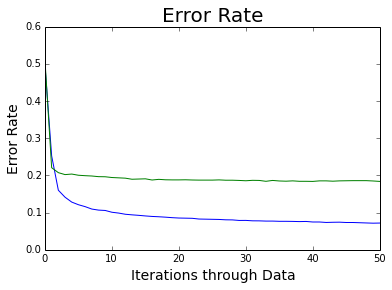

Final testing error: 0.183851292477
Final training error: 0.0719186473903


In [275]:
train_er = np.array(train_error)
test_er = np.array(test_error)
plt.plot(train_er[:,0], train_er[:,1])
plt.plot(test_er[:,0], test_er[:,1])
plt.title("Error Rate", fontsize=20)
plt.xlabel("Iterations through Data", fontsize=14)
plt.ylabel("Error Rate", fontsize=14)
plt.ylim(0)
plt.show()

print "Final testing error: " + str(test_er[-1][1])
print "Final training error: " + str(train_er[-1][1])

# Collapsing to Speaker Level 
Merge bigrams to have speakers-all_bigrams. Keep only House of Representatives. 

In [20]:
all_features = all_cong_features.collect()

In [21]:
final_features = {}
for f in all_features: 
    name = f['speaker']
    if f['chamber'] == 'senate':
        continue 
    if name not in final_features: 
        final_features[name] = {} 
    if 'features' not in final_features[name]:
        final_features[name]['features'] = []
        final_features[name]['chamber'] = f['chamber']
        final_features[name]['dwnom1'] = f['dwnom1']
        final_features[name]['dwnom2'] = f['dwnom2']
        final_features[name]['party'] = f['party']
    final_features[name]['features'] += f['features']

In [22]:
len(bigrams_list)

9998

# Summary Statistics

### Number of Speakers

In [23]:
all_speakers = set() 
ac = all_cong.collect()
for speech in ac: 
    if (speech['speaker'], speech['party'], speech['chamber']) not in all_speakers: 
        all_speakers.add((speech['speaker'], speech['party'], speech['chamber']))
all_speakers = [l for l in list(all_speakers) if l[2]!='senate']
print "There are %d unique speakers" % len(all_speakers)
print "%d of which are Republican" % len([l for l in all_speakers if l[1]==1])

There are 408 unique speakers
224 of which are Republican


In [28]:
def num_words(x): 
    x = len(x['text'].split())
    return x
num_speeches = all_cong.count()
print "Average words per speech: " + str(all_cong.map(num_words).reduce(lambda a, b: a+b)/num_speeches)
print "Number of speeches: %d " % num_speeches

Average words per speech: 418
Number of speeches: 11605 


In [25]:
num_feats = [] 
for i in range(len(final_features.keys())):
    num_feats.append(len(final_features[final_features.keys()[i]]['features']))
print "Average number of active features:"
reduce(lambda x, y: x+y, num_feats)/float(len(num_feats))

Average number of active features:


946.5171568627451

In [27]:
def num_features(x): 
    x = len(x['features'])
    return x
print "Average active features per speech: " + str(all_cong_features.map(num_features).reduce(lambda a, b: a+b)/all_cong_features.count())

Average active features per speech: 37


# Exporting to Use in R
Convert to 2d matrix then save as MM to read in R. Already have bigram_to_index dictionary, but need to update it to make room so first 4 cols are [speaker, party, dwnom1, dwnom2]. Also need speaker_to_index dictionary so that we can navigate the 2d matrix. 

THIS MAKES THEM INTO COUNTS, NOT BINARY

In [29]:
speaker_to_index = {} 
index_to_speaker = {}
i = 0
for speaker in all_speakers: 
    speaker_to_index[speaker[0]] = i
    index_to_speaker[i] = speaker[0]
    i+=1

bigram_to_index_2 = {}
i = 3
for bg in bigrams_list: 
    bigram_to_index_2[bg] = i
    i+=1
index_to_bigram_2 = {}
for key in bigram_to_index_2: 
    index_to_bigram_2[bigram_to_index_2[key]] = key

In [30]:
len_bg = len(bigrams_list)+3
len_as = len(all_speakers)
main = [[0]*len_bg for _ in range(len_as)]

In [31]:
for speaker in final_features: 
    main[speaker_to_index[speaker]][0] = int(final_features[speaker]['party'])
    main[speaker_to_index[speaker]][1] = float(final_features[speaker]['dwnom1'])
    main[speaker_to_index[speaker]][2] = float(final_features[speaker]['dwnom2'])
    for feature in final_features[speaker]['features']: 
        main[speaker_to_index[speaker]][bigram_to_index_2[feature]] += 1

In [32]:
covars = np.asmatrix(main)[:,:3]
cong2012 = np.asmatrix(main)[:,3:]

In [33]:
covars_speaker_names = [[l[0].replace(".", "")] for l in all_speakers]
covars_colnames = ["speaker", "party", "dwnom1", "dwnom2"]
covars = np.asmatrix(main)[:,:3].tolist()
covars = np.asarray([covars_colnames] + [l[0]+l[1] for l in zip(covars_speaker_names, covars)])

In [34]:
cong2012_list = cong2012.tolist()
print len(cong2012_list[0])
cong2012_colnames =  [l[0]+"."+l[1] for l in bigrams_list]
cong2012_list = [cong2012_colnames] + cong2012_list

9998


In [35]:
covars = covars.tolist()
for i in [333, 13]: # Two candidates with super weird SR projections. Ditch em.  
    del cong2012_list[i]
    del covars[i]

In [36]:
# this makes sure that there are at least 2 unique speakers for each bigram. Somehow a few snuck through the previous filter
maxes = []
indices = []
bad_bgs = []
t = np.asarray(cong2012_list)
for i in range(0, len(t[0])): 
    new_max = max(t[1:][:,i])
    if float(new_max)==0:
        print t[0][i]
        indices.append(i)
        bad_bgs.append(t[0][i])
    maxes.append(new_max)
indices = sorted(indices, reverse=True)
for row in cong2012_list: 
    for i in indices: 
        del row[i]

wisdom.strength
pleas.god
obama.eye
senat.eye
madam.presid
presid.rise
uniform.god
absenc.quorum
suggest.absenc
bless.women
leg.arm
close.god
lejeun.marin
iraq.god
proceed.call
arm.hold


In [45]:
#cong2012_final[0] = [str(0) for l in cong2012_final[0]]
import csv
f = csv.writer(open("../../ECON_407/Primary Elections/R/covars.csv", "wb+"))
for row in covars: 
    f.writerow(row)

In [54]:
f2 = csv.writer(open("../../ECON_407/Primary Elections/R/cong2012counts.csv", "wb+"))
for row in cong2012_list: 
    f2.writerow(row)

In [40]:
subsamp = np.asarray(cong2012_list)#[:,:1500]

In [39]:
print len(cong2012_list)
print len(cong2012_list[0])
print len(bigrams_list)
print len(bad_bgs)

407
9982
9998
16


# Candidates Polarization

In [40]:
candidate_features = candidates_bigrams.map(filter_features)

In [41]:
cand_feats = candidate_features.collect()
cand_feats = cand_feats[1:]

### Collapse to speaker-month-features

In [42]:
set_dates = set()
for item in cand_feats: 
    set_dates.add(item['date'][2:])

In [43]:
final_cand_feats = {}
for item in cand_feats:
    name = item['speaker']
    date = item['date'].strip()[2:]
    if name not in final_cand_feats:
        final_cand_feats[name] = {} 
    if date not in final_cand_feats[name]: 
        final_cand_feats[name][date] = {}
    if 'features' not in final_cand_feats[name][date]:
        final_cand_feats[name][date]['features'] = [] 
        final_cand_feats[name][date]['num_bigrams'] = 0
        final_cand_feats[name][date]['num_features'] = 0
    final_cand_feats[name][date]['features'] += [l[0]+"."+l[1] for l in item['features']]
    final_cand_feats[name][date]['num_bigrams'] += item['num_bigrams']
    final_cand_feats[name][date]['num_features'] += item['num_features']       

### DON'T USE THIS ANYMORE: Read in betas from R (saved in csv)

In [1307]:
feats_coefs = {}
with open("../../ECON_407/Primary Elections/R/coefs.csv", 'rU') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
         feats_coefs[row[0]] = row[1]

### Add in sum of features coefs to the final_cand_features dictionary for each speaker-month

In [1308]:
def score_monthly_candiates(coefs, features_dict): 
    rv = {}
    for speaker in features_dict:
        rv[speaker] = {} 
        for date in features_dict[speaker]:
            rv[speaker][date] = {} 
            rv[speaker][date]['num_bigrams'] = features_dict[speaker][date]['num_bigrams']
            rv[speaker][date]['num_features'] = features_dict[speaker][date]['num_features']
            rv[speaker][date]['score'] = 0.0
            for feat in features_dict[speaker][date]['features']: 
                if feat in coefs: 
                    rv[speaker][date]['score'] += float(coefs[feat])
    return rv

cand_scores = score_monthly_candiates(feats_coefs, final_cand_feats)

In [1309]:
from datetime import datetime
def convert_date(date): 
    date = date[:3] + " " + date[3:]
    return datetime.strptime(date, '%b %Y') #matplotlib.dates.date2num(

def create_cand_scores(candidate): 
    rv = []
    for speaker in cand_scores: 
        for date in cand_scores[speaker]: 
            if speaker==candidate and cand_scores[speaker][date]['num_features']!=0: 
                rv.append([convert_date(date), cand_scores[speaker][date]['score'], cand_scores[speaker][date]['score']/cand_scores[speaker][date]['num_features'],\
                           cand_scores[speaker][date]['score']/cand_scores[speaker][date]['num_bigrams'], cand_scores[speaker][date]['num_features'],\
                           cand_scores[speaker][date]['num_bigrams']])       
    return sorted(rv, key = lambda x: x[0])

romney = create_cand_scores("Mitt Romney")
gingrich = create_cand_scores("Newt Gingrich")
paul = create_cand_scores("Ron Paul")
obama = create_cand_scores("Barack Obama")
cain = create_cand_scores("Herman Cain")
santorum = create_cand_scores("Rick Santorum")
perry = create_cand_scores("Rick Perry")
bachmann = create_cand_scores("Michele Bachmann")
huntsman = create_cand_scores("Jon Huntsman")
pawlenty = create_cand_scores("Tim Pawlenty")


In [1310]:
def reduce_to_bimonthly(cand_scores): 
    rv = []
    if len(cand_scores)%2==0: 
        range_nums = range(0, len(cand_scores),2)
    else: 
        range_nums = range(0, len(cand_scores)-1,2)
    for i in range_nums:
        total = cand_scores[i][1]+cand_scores[i+1][1]
        by_feat = total/(cand_scores[i][4]+cand_scores[i+1][4])
        by_bigram = total/(cand_scores[i][5]+cand_scores[i+1][5])
        rv.append([cand_scores[i][0], total, by_feat, by_bigram])
    if len(cand_scores)%2!=0:
        rv.append([cand_scores[-1][0], cand_scores[-1][1], cand_scores[-1][2], cand_scores[-1][3]])
    return rv

## Exporting Candidate Vectors to Use in R

In [46]:
# List of all candidate-date combos
all_cand_dates = []
for speaker in final_cand_feats:
    for date in final_cand_feats[speaker]:
        all_cand_dates.append(str(speaker.split()[0])+"_"+str(speaker.split()[1])+"_"+str(date))

In [47]:
# Intialize and fill main array 
len_cd = len(all_cand_dates)
len_feats = len(cong2012_list[0])
main_cand = [[0]*len_feats for _ in range(len_cd)]
for speaker in final_cand_feats:
    for date in final_cand_feats[speaker]:
        key = str(speaker.split()[0])+"_"+str(speaker.split()[1])+"_"+str(date)
        ind_r = all_cand_dates.index(key)
        for feat in final_cand_feats[speaker][date]['features']:
            if feat not in bad_bgs and feat in cong2012_list[0]: #list of ones that have <2 congressmen saying them for whatever reason 
                ind_c = cong2012_list[0].index(feat)
                main_cand[ind_r][ind_c]+=1

In [48]:
# Add header of bigram names
main_cand_final = [cong2012_list[0]] + main_cand
assert(len(main_cand_final)==len_cd+1)

In [49]:
# convert to csv [should have 103 rows]
f3 = csv.writer(open("../../ECON_407/Primary Elections/R/pres_cand_counts.csv", "wb+"))
for row in main_cand_final: 
    f3.writerow(row)

In [55]:
# Create csv of Candidate - Date that aligns with above 
f4 = csv.writer(open("../../ECON_407/Primary Elections/R/cand_date_labels.csv", "wb+"))
for cand in all_cand_dates: 
    rv = cand.split("_")
    f4.writerow([rv[1], rv[2]])

In [69]:
## TOTAL SPEECH BY MONTH ## 
import pickle
romney_counts = []
for i in range(len(all_cand_dates)): 
    if all_cand_dates[i][:4]=="Mitt": 
        romney_counts.append([all_cand_dates[i][-7:], np.sum(main_cand_final[i])])
pickle.dump(romney_counts, open("romney_counts.p", "wb"))

In [64]:
all_cand_dates[15][-7:]

'apr2012'

### Romney & Obama Pre-Post Election

In [57]:
pre_post_rows = ["Romney_primary", "Romney_general", "Obama_primary", "Obama_general", "Bachmann_primary", "Bachmann_general", "Paul_primary", "Paul_general"]
main_pre_post = [[0]*len_feats for _ in range(len(pre_post_rows))]
for speaker in final_cand_feats:
    if speaker!="Mitt Romney" and speaker!="Barack Obama" and speaker!="Michele Bachmann" and speaker!="Ron Paul": 
        continue
    for date in final_cand_feats[speaker]:
        month = date[:3]
        year = date[3:]
        name = speaker.split()[1]
        if (year=='2012' and month in ['jun', 'jul', 'aug', 'sep', 'oct']) or (year=="2011" and month in ['nov','dec']):
            ind1 = pre_post_rows.index(name+"_general")
        else: 
            ind1 = pre_post_rows.index(name+"_primary")
        for feat in final_cand_feats[speaker][date]['features']: 
            main_pre_post[ind1][cong2012_list[0].index(feat)] +=1
            
main_pre_post = [cong2012_list[0]] + main_pre_post

In [58]:
f5 = csv.writer(open("../../ECON_407/Primary Elections/R/pre_post_counts_2.csv", "wb+"))
for row in main_pre_post: 
    f5.writerow(row)

In [56]:
# labels 
f6 = csv.writer(open("../../ECON_407/Primary Elections/R/pre_post_labels.csv", "wb+"))
for cand in pre_post_rows: 
    f6.writerow([cand])

In [131]:
import numpy as np
for row in main_pre_post[1:]: 
    print np.mean(np.asarray(row))

1.82815073138
1.23074687591
0.482708514967
2.18996415771
0.441150828248
0.0
0.795408311537
0.0


# Most Loaded Phrases Primary/General


In [179]:
temp = [] 
import math
with open("../../ECON_407/Primary Elections/R/loadings.csv", 'rU') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader: 
        temp.append(row)
loadings = [l + [float(l[2])+float(l[3])] for l in temp[1:]]

In [180]:
romney_primary_count = np.sum(main_pre_post[1])
romney_general_count = np.sum(main_pre_post[2])
obama_primary_count = np.sum(main_pre_post[3])
obama_general_count = np.sum(main_pre_post[4])
print romney_primary_count, romney_general_count, obama_primary_count, obama_general_count

16486 14484 5493 21867


In [181]:
romney_primary_loadings = zip(main_pre_post[0], main_pre_post[1])
for i in range(len((romney_primary_loadings))):
    val = (loadings[i][-1]*romney_primary_loadings[i][1])/romney_primary_count
    romney_primary_loadings[i]+=(val,)

romney_general_loadings = zip(main_pre_post[0], main_pre_post[2])
for i in range(len((romney_general_loadings))):
    val = (loadings[i][-1]*romney_general_loadings[i][1])/romney_general_count
    romney_general_loadings[i]+=(val,)
    

In [182]:
n = 50
p =  [[l[0], round(l[-1],4)] for l in sorted(romney_primary_loadings, key=lambda x: abs(x[-1]), reverse=True)[:n]]
g = [[l[0], round(l[-1],4)] for l in sorted(romney_general_loadings, key=lambda x: abs(x[-1]), reverse=True)[:n]]
for i in range(len(p)): 
    print str(p[i]) + "\t\t\t " + str(g[i])


[u'mitt.romney', -0.0552]			 [u'mitt.romney', -0.0701]
[u'barack.obama', 0.0114]			 [u'middl.class', -0.033]
[u'middl.class', -0.0073]			 [u'barack.obama', 0.0128]
[u'free.enterpris', 0.0063]			 [u'wall.street', -0.0108]
[u'wall.street', -0.006]			 [u'currenc.manipul', -0.0083]
[u'econom.freedom', 0.006]			 [u'manipul.currenc', -0.0063]
[u'newt.gingrich', -0.0058]			 [u'busi.owner', 0.0061]
[u'super.pac', -0.0056]			 [u'china.currenc', -0.006]
[u'obama.administr', 0.0051]			 [u'tax.cut', -0.005]
[u'illeg.immigr', 0.0049]			 [u'class.famili', -0.0049]
[u'rais.tax', 0.0038]			 [u'job.creator', 0.0048]
[u'nation.debt', 0.0037]			 [u'fox.news', 0.0046]
[u'obama.care', -0.0036]			 [u'rais.tax', 0.0044]
[u'repeal.obamacar', 0.0032]			 [u'free.enterpris', 0.0044]
[u'senat.obama', 0.0029]			 [u'middl.incom', -0.0042]
[u'fox.news', 0.0026]			 [u'obama.administr', 0.004]
[u'cap.trade', 0.0026]			 [u'repeal.obamacar', 0.0037]
[u'labor.statist', -0.0026]			 [u'th.district', 0.0036]
[u'bureau.labor

In [127]:
obama_primary_loadings = zip(main_pre_post[0], main_pre_post[3])
for i in range(len((obama_primary_loadings))):
    val = (loadings[i][-1]*obama_primary_loadings[i][1])/obama_primary_count
    obama_primary_loadings[i]+=(val,)

obama_general_loadings = zip(main_pre_post[0], main_pre_post[4])
for i in range(len((obama_general_loadings))):
    val = (loadings[i][-1]*obama_general_loadings[i][1])/obama_general_count
    obama_general_loadings[i]+=(val,)

In [183]:
p =  [[l[0], round(l[-1],4)] for l in sorted(obama_primary_loadings, key=lambda x: abs(x[-1]), reverse=True)[:n]]
g = [[l[0], round(l[-1],4)] for l in sorted(obama_general_loadings, key=lambda x: abs(x[-1]), reverse=True)[:n]]
for i in range(len(p)): 
    print str(p[i]) + "\t\t\t " + str(g[i])


[u'middl.class', -0.0298]			 [u'middl.class', -0.0472]
[u'thrive.middl', -0.0262]			 [u'tax.cut', -0.0297]
[u'tax.cut', -0.0158]			 [u'class.famili', -0.0193]
[u'wall.street', -0.0102]			 [u'thrive.middl', -0.0148]
[u'wealthiest.american', -0.01]			 [u'tax.break', -0.0131]
[u'clean.energi', -0.0096]			 [u'ladder.opportun', -0.0096]
[u'student.loan', -0.0072]			 [u'war.iraq', -0.0077]
[u'send.resum', -0.0065]			 [u'presid.don', 0.0077]
[u'insur.compani', -0.0065]			 [u'wall.street', -0.0073]
[u'war.iraq', -0.0059]			 [u'ship.job', -0.0071]
[u'prevent.care', -0.0058]			 [u'communiti.colleg', -0.0063]
[u'million.job', -0.0055]			 [u'insur.compani', -0.006]
[u'ladder.opportun', -0.0055]			 [u'wealthiest.american', -0.0056]
[u'class.famili', -0.0054]			 [u'cut.tax', -0.0053]
[u'marin.base', -0.0053]			 [u'medicar.voucher', -0.0052]
[u'deni.coverag', -0.0052]			 [u'troop.home', -0.0052]
[u'millionair.tax', -0.0051]			 [u'invest.educ', -0.0048]
[u'street.reform', -0.0049]			 [u'rebuild.road',

In [158]:
sorted(romney_primary_loadings, key=lambda x: x[2], reverse=False)

[(u'mitt.romney', 501, -0.05523396006519248),
 (u'middl.class', 57, -0.007340052637578646),
 (u'wall.street', 57, -0.0060275960007918905),
 (u'newt.gingrich', 77, -0.005810658900754774),
 (u'super.pac', 13, -0.005578517114381953),
 (u'obama.care', 10, -0.0035762803424169475),
 (u'labor.statist', 67, -0.002600781701373594),
 (u'bureau.labor', 68, -0.0025614507377724146),
 (u'middl.incom', 22, -0.002326927265086112),
 (u'class.famili', 15, -0.0022319777962149794),
 (u'near.million', 28, -0.001813190393379646),
 (u'cut.tax', 28, -0.0018016514891858815),
 (u'davi.bacon', 13, -0.0017954789479860019),
 (u'tax.cut', 17, -0.0017209578050685788),
 (u'lost.job', 26, -0.0016256946760358705),
 (u'los.angel', 23, -0.001502964807735945),
 (u'manipul.currenc', 3, -0.0012774671249245451),
 (u'tea.parti', 14, -0.0012756948533588753),
 (u'deficit.china', 3, -0.0012701261928530685),
 (u'home.foreclosur', 6, -0.0012652566417079704),
 (u'econom.recoveri', 25, -0.0012545728225240582),
 (u'suppress.vote', 4,